# SYSID - Atividade 06

Aluno: Pedro Henrique Cardoso Paulo<br>

Professor: Helon

## Objetivo

Nessa atividade vamos tentar aplicar os fundamentos da identificação contínua de sistemas. Devido a problemas com o Octave essa atividade será feita em Python, fazzendo uso das bibliotecas `scikitt-learn`, `control`, `scipy` e `numpy`

## Arquivos de suporte

Na pasta deste notebook poderão ser encontrados dois arquivos com funções e classes de suporte:

* <a href="./time_processing.py">time_processing.py</a>: pacote com função para reamostragem do sinal no tempo fazendo uso de interpolação
* <a href="./ContinuousDerivativePreprocessor.py">ContinuousDerivativePreprocessor.py</a>: tentativa de implementar, com a sitaxe sklearn um preprocessador de derivadas temporais

## Passo 0 - Importando bibliotecas

In [1]:
#Desabilitando warnings
#def warn(*args, **kwargs):
#    pass
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
#warnings.warn = warn

# Pacotes padrao
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import datetime

#sysidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.general_estimators.narx import NARX
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

#Pipeline
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.model_selection import RandomizedSearchCV

# Scores
from sklearn.metrics import r2_score

#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [2]:
data = np.genfromtxt('../data/robot_arm.dat')
X1 = data[:,0].reshape(-1,1)
y = data[:,1].reshape(-1,1)

### 0.2 - Visualizando dados

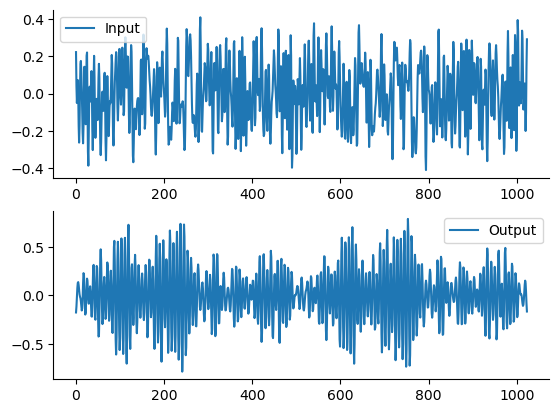

In [3]:
fig, ax = plt.subplots(2,1)
ax[0].plot(X1, label='Input')
ax[1].plot(y, label='Output')
ax[0].legend()
ax[1].legend()

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [4]:
p_train = 0.5 #50% treino

### 1.2 - Separando os conjuntos

In [5]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[n_train:,:]
y_te = y[n_train:,:]

## Passo 2 - Iniciando a construção do modelo ARMAX/NARMAX

Para essa atividade, vamos usar a biblioteca sysidentpy. Essa biblioteca guarda grandes similaridades com bibliotecas da área de machine learning, como `scikit-learn`, `tensorflow` e `pytorch`.

### 2.1 - Selecionando a função-base

In [108]:
basis_function = Polynomial(degree=1)

### 2.2 - Selecionando a arquitetura

In [153]:
na = 4
nb = 6
ne = 1
model = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=na+nb+ne,
    model_type='NARMAX',
    #extended_least_squares=True,
)

## Passo 3 - Realizando ajuste inicial

### 3.1 - Performando o ajuste

In [154]:
model.fit(X=X1_tr, y=y_tr)

In [144]:
model.theta.shape

(10, 1)

In [145]:
r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-4),-1.0202E+00,8.82401672E-01
1,x1(k-2),9.1789E-01,3.29600726E-02
2,y(k-1),3.2563E+00,1.02592690E-02
3,y(k-2),-4.6139E+00,6.85312782E-02
4,y(k-3),3.2784E+00,5.50065803E-03
5,x1(k-6),1.9436E-01,8.12464352E-05
6,x1(k-1),-2.5098E-01,1.93346008E-05
7,x1(k-5),-8.1747E-01,1.18151736E-05
8,x1(k-3),-1.5026E+00,3.08671003E-05
9,x1(k-4),1.4588E+00,1.80355117E-04


## Passo 4 - Comparando os resultados

### 4.1 - Calculando predição OSA

In [146]:
y_tr_pr_OSA = model.predict(X=X1_tr, y=y_tr,steps_ahead=1)
y_te_pr_OSA = model.predict(X=X1_te, y=y_te,steps_ahead=1)

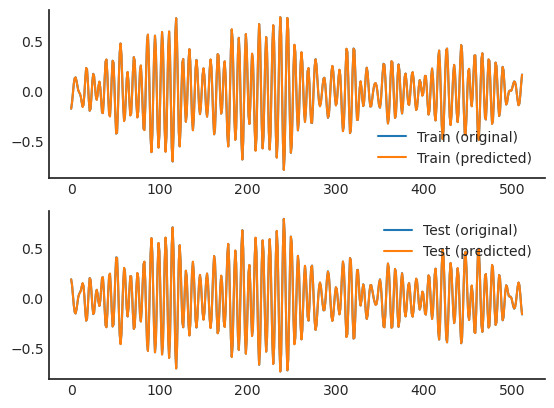

In [147]:
fig, ax = plt.subplots(2,1)
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_OSA, label='Train (predicted)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_OSA, label='Test (predicted)')
ax[0].legend()
ax[1].legend()

In [148]:
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_OSA))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_OSA))

R2 score for OSA prediction (train) : 0.9999658859069441
R2 score for OSA prediction (test)  : 0.9999602330325235


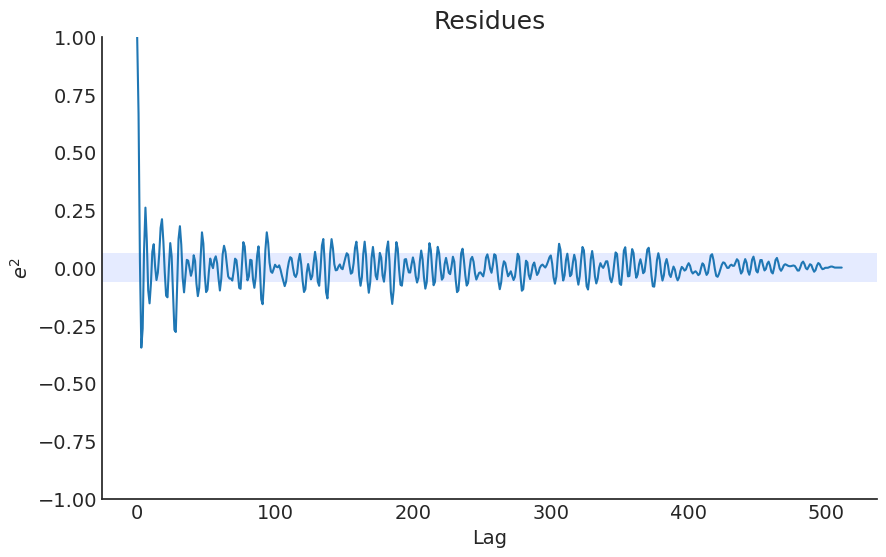

In [149]:
ee = compute_residues_autocorrelation(y_tr, y_tr_pr_OSA)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")

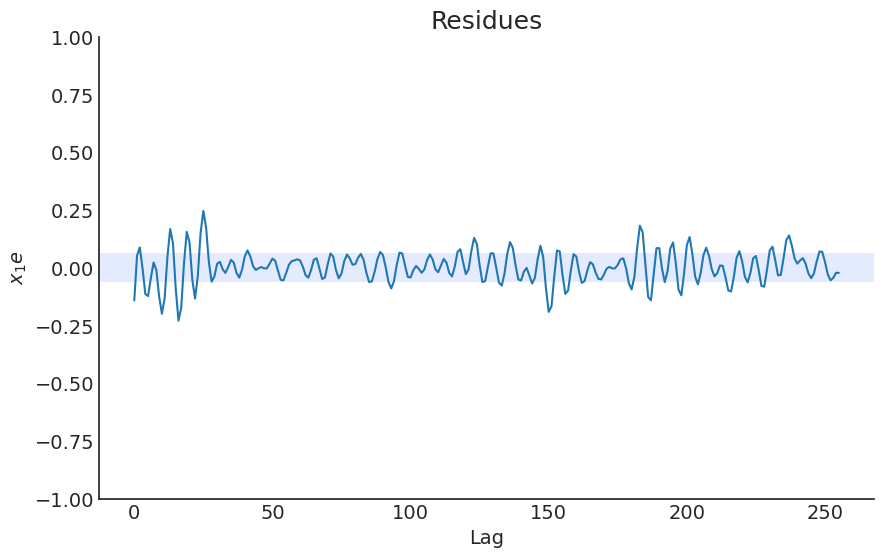

In [150]:
x1e = compute_cross_correlation(y_tr, y_tr_pr_OSA, X1_tr)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

### 4.3 - Calculando predição FS

In [155]:
y_tr_pr_FS = model.predict(X=X1_tr, y=y_tr,steps_ahead=None)
y_te_pr_FS = model.predict(X=X1_te, y=y_te,steps_ahead=None)

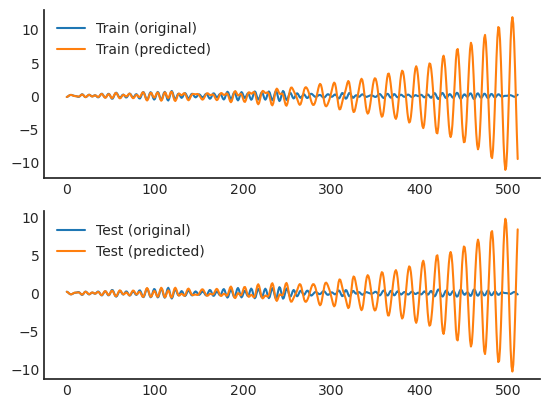

In [156]:
fig, ax = plt.subplots(2,1)
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_FS, label='Train (predicted)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_FS, label='Test (predicted)')
ax[0].legend()
ax[1].legend()

In [157]:
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_FS))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_FS))

R2 score for OSA prediction (train) : -107.45111246511944
R2 score for OSA prediction (test)  : -85.12925960766381


### 4.4 - Calculando predição 100 passos a frente

In [158]:
y_tr_pr_FS = model.predict(X=X1_tr, y=y_tr,steps_ahead=100)
y_te_pr_FS = model.predict(X=X1_te, y=y_te,steps_ahead=100)

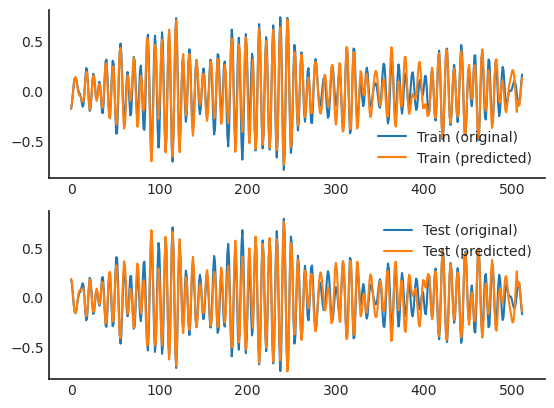

In [159]:
fig, ax = plt.subplots(2,1)
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_FS, label='Train (predicted)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_FS, label='Test (predicted)')
ax[0].legend()
ax[1].legend()

In [160]:
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_FS))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_FS))

R2 score for OSA prediction (train) : 0.8913686658166542
R2 score for OSA prediction (test)  : 0.8853782027780869


## Passo 4 - Tentando aplicar GridSearchCV no ARMAX

Infelizmente, a implementação do sysidentpy não permite seu uso em conjunto com as ferramentas de busca aleatória do scikit-learn, de modo que vamos fazer uma busca em grade por meuio de um loop explícito

### 4.1 - Definindo o range das variáveis

In [83]:
xlag_range = range(1,10)
ylag_range = range(1,10)
elag_range = range(1,10)

### 4.2 - Alocando estrutura para salvar os resultados

In [84]:
results_gsearch = {
    'xlag'        :[],
    'ylag'        :[],
    'elag'        :[],
    'R2_OSA_TRAIN':[],
    'R2_FS_TRAIN' :[],
    'R2_OSA_TEST' :[],
    'R2_FS_TEST'  :[],
}

### 4.3 - Executando o loop

In [161]:
n_iter = 0
iters_to_print = 100
for xlag in xlag_range:
    for ylag in ylag_range:
        for elag in elag_range:
            n_iter += 1
            if n_iter % iters_to_print == 0:
                print(f'Executing iteration: {n_iter}')
            model = FROLS(
                    order_selection=True,
                    ylag=ylag, xlag=xlag,elag=elag,
                    basis_function=basis_function,
                    n_info_values=100,
                    #n_terms=na+nb+ne,
                    model_type='NARMAX',
                    extended_least_squares=(elag > 1),
                        )
            
            model.fit(X=X1_tr, y=y_tr)

            y_tr_pr_OSA = model.predict(X=X1_tr, y=y_tr,steps_ahead=1)
            y_te_pr_OSA = model.predict(X=X1_te, y=y_te,steps_ahead=1)
            y_tr_pr_FS  = model.predict(X=X1_tr, y=y_tr,steps_ahead=None)
            y_te_pr_FS  = model.predict(X=X1_te, y=y_te,steps_ahead=None)

            results_gsearch['xlag'].append(xlag)
            results_gsearch['ylag'].append(ylag)
            results_gsearch['elag'].append(elag)

            results_gsearch['R2_OSA_TRAIN'].append(r2_score(y_tr,y_tr_pr_OSA))
            results_gsearch['R2_FS_TRAIN'].append(r2_score(y_tr,y_tr_pr_FS))
            results_gsearch['R2_OSA_TEST'].append(r2_score(y_tr,y_te_pr_OSA))
            results_gsearch['R2_FS_TEST'].append(r2_score(y_tr,y_te_pr_FS))

results_df = pd.DataFrame(results_gsearch)
            

Executing iteration: 100
Executing iteration: 200
Executing iteration: 300
Executing iteration: 400
Executing iteration: 500
Executing iteration: 600
Executing iteration: 700


In [134]:
results_df.sort_values(['R2_FS_TEST', 'R2_FS_TRAIN'], ascending=False).head(5)

,xlag,ylag,elag,R2_OSA_TRAIN,R2_FS_TRAIN,R2_OSA_TEST,R2_FS_TEST
153,1,8,1,0.999934,-0.250149,-2.930908,0.123346
154,1,8,2,0.999934,-0.250149,-2.930908,0.123346
155,1,8,3,0.999934,-0.250149,-2.930908,0.123346
156,1,8,4,0.999934,-0.250149,-2.930908,0.123346
157,1,8,5,0.999934,-0.250149,-2.930908,0.123346
